In [1]:
# generate a occupancy grid groundtruth label
import matplotlib.pyplot as plt
import numpy as np
import torch
from prettytable import PrettyTable

from l5kit.configs import load_config_data
from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.dataset import EgoDataset, OfflineEgoDataset
from l5kit.rasterization import build_rasterizer

from l5kit.simulation.dataset import SimulationConfig
from l5kit.simulation.unroll import ClosedLoopSimulator
from l5kit.cle.closed_loop_evaluator import ClosedLoopEvaluator, EvaluationPlan
from l5kit.cle.metrics import (CollisionFrontMetric, CollisionRearMetric, CollisionSideMetric,
                               DisplacementErrorL2Metric, DistanceToRefTrajectoryMetric)
from l5kit.cle.validators import RangeValidator, ValidationCountingAggregator

from l5kit.visualization.visualizer.zarr_utils import simulation_out_to_visualizer_scene
from l5kit.visualization.visualizer.visualizer import visualize
from bokeh.io import output_notebook, show
from l5kit.data import MapAPI

from collections import defaultdict
import os

# set env variable for data
os.environ["L5KIT_DATA_FOLDER"] = "/mnt/scratch/v_liuhaolan/l5kit_data"
dm = LocalDataManager(None)
# get config
cfg = load_config_data("./config.yaml")



# rasterisation and perturbation
rasterizer = build_rasterizer(cfg, dm)

# ===== INIT DATASET

#eval_cfg = cfg["train_data_loader"]
eval_cfg = cfg["val_data_loader"]

rasterizer = build_rasterizer(cfg, dm)
eval_zarr = ChunkedDataset(dm.require(eval_cfg["key"])).open()
eval_dataset = EgoDataset(cfg, eval_zarr, rasterizer)
offline_dataset = OfflineEgoDataset(cfg, eval_zarr, rasterizer)

print(eval_dataset)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|   16220    |  4030296   | 312617887  |    29277930   |      111.97     |        248.48        |        77.57         |        24.85         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


In [8]:
data = offline_dataset[2000]

# the last four frames + current frames
print(len(data["agent"]))

print((data["agent"][0]).shape)


print((data["agent"][0]))
# the format

5
(33,)
[([  637.89550781, -1365.08825684], [3.4329474 , 1.5729724 , 1.3533974 ], -2.1275232 , [-7.6077371e+00, -1.1739139e+01],   2, [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
 ([  683.8927002 , -1360.56652832], [4.3700733 , 1.901273  , 1.4002228 ],  2.5774345 , [-4.6575513e-01,  3.2580417e-01],   3, [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
 ([  653.89044189, -1367.6517334 ], [4.3139215 , 1.7542387 , 1.320439  ],  0.947771  , [-6.0970202e-02,  2.8813925e-02],   4, [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
 ([  680.03070068, -1354.31018066], [4.3060427 , 1.7071527 , 1.494734  ],  2.54697   , [-3.8216536e+00,  2.6984189e+00],   5, [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
 ([  683.70404053, -1364.82946777], [3.812384  , 1.7687201 , 1.0878534 ],  2.5835192 , [-1.0536459e-02, -2.0446146e-02],   7, [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
 ([  645.827

(112, 112, 3)
10


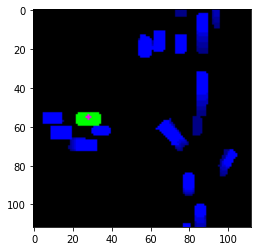

In [7]:
from l5kit.geometry import transform_points
from l5kit.visualization import TARGET_POINTS_COLOR, draw_trajectory

box_cfg = cfg
box_cfg["raster_params"]["map_type"] = "box_debug"
box_rasterizer = build_rasterizer(box_cfg, dm)

box_dataset = EgoDataset(cfg, eval_zarr, box_rasterizer)

se_cfg = cfg
se_cfg["raster_params"]["map_type"] = "semantic_debug"
se_rasterizer = build_rasterizer(se_cfg, dm)
se_dataset = EgoDataset(cfg, eval_zarr, se_rasterizer)


data_ego = box_dataset[2000]
im_ego = box_rasterizer.to_rgb(data_ego["image"].transpose(1, 2, 0))
print(im_ego.shape)
target_positions = transform_points(data_ego["target_positions"], data_ego["raster_from_agent"])
draw_trajectory(im_ego, target_positions, TARGET_POINTS_COLOR)
plt.imshow(im_ego)

print(len(data_ego["goal_list"]))



(112, 112, 3)


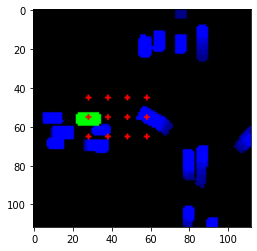

In [9]:
from l5kit.geometry import transform_points
from l5kit.visualization import TARGET_POINTS_COLOR, draw_trajectory

box_cfg = cfg
box_cfg["raster_params"]["map_type"] = "box_debug"
box_rasterizer = build_rasterizer(box_cfg, dm)

box_dataset = EgoDataset(cfg, eval_zarr, box_rasterizer)

se_cfg = cfg
se_cfg["raster_params"]["map_type"] = "semantic_debug"
se_rasterizer = build_rasterizer(se_cfg, dm)
se_dataset = EgoDataset(cfg, eval_zarr, se_rasterizer)


data_ego = box_dataset[2010]
im_ego = box_rasterizer.to_rgb(data_ego["image"].transpose(1, 2, 0))
print(im_ego.shape)
target_positions = transform_points(data_ego["target_positions"], data_ego["raster_from_agent"])
draw_trajectory(im_ego, target_positions, TARGET_POINTS_COLOR)

from l5kit.geometry import rotation33_as_yaw, transform_point, transform_points

import cv2



raster_from_world = data_ego["raster_from_world"]

#centerline_area = (data_ego["goal_list"])
centerline_area = []

target_positions_pixels = transform_points(data_ego["target_positions"], data_ego["raster_from_agent"])
original_pixel = target_positions_pixels[0]

#centerline_area.append((original_pixel[0],original_pixel[1]))
for i in range(0,31,10):
    for j in range(-10,11,10):
        centerline_area.append((original_pixel[0]+i,original_pixel[1]+j))


for k in centerline_area:
#        print(j)
    xy_points = k
#    xy_points = (transform_point(k, raster_from_world))
#        print(xy_points)
    cv2.circle(im_ego, (int(xy_points[0]),int(xy_points[1])), radius=1, color=(255, 0, 0), thickness=-1)
    
    
    
plt.imshow(im_ego)

In [ ]:
eval_zarr.agents

In [ ]:
data_ego = eval_dataset[2050]

traj = (data_ego["target_positions"])
im_ego = rasterizer.to_rgb(data_ego["image"].transpose(1, 2, 0))

cnt = 0
for j, _ in enumerate(traj):
    traj[j] = traj[j] + cnt
    cnt = cnt + 1

target_positions = transform_points(traj, data_ego["raster_from_agent"])
draw_trajectory(im_ego, target_positions, TARGET_POINTS_COLOR)#, yaws=data_ego["target_yaws"])
plt.imshow(im_ego)

print(data_ego["target_yaws"][0])

In [ ]:
data_ego = eval_dataset[2050]
im_ego = rasterizer.to_rgb(data_ego["image"].transpose(1, 2, 0))

target_positions = transform_points(data_ego["target_positions"], data_ego["raster_from_agent"])
draw_trajectory(im_ego, target_positions, TARGET_POINTS_COLOR)
#plt.imshow(im_ego)

for i in data_ego:
    print(i)

In [ ]:
from l5kit.planning import utils
from l5kit.simulation.dataset import SimulationConfig, SimulationDataset

from l5kit.rasterization import EGO_EXTENT_LENGTH, EGO_EXTENT_WIDTH
simulated_extent = np.r_[EGO_EXTENT_LENGTH, EGO_EXTENT_WIDTH]

from enum import IntEnum
from typing import Callable, Optional, Tuple


def detect_collision(pred_centroid: np.ndarray, pred_yaw: np.ndarray,
                     pred_extent: np.ndarray, target_agents: np.ndarray):
    """
    Computes whether a collision occured between ego and any another agent.
    Also computes the type of collision: rear, front, or side.
    For this, we compute the intersection of ego's four sides with a target
    agent and measure the length of this intersection. A collision
    is classified into a class, if the corresponding length is maximal,
    i.e. a front collision exhibits the longest intersection with
    egos front edge.
    .. note:: please note that this funciton will stop upon finding the first
              colision, so it won't return all collisions but only the first
              one found.
    :param pred_centroid: predicted centroid
    :param pred_yaw: predicted yaw
    :param pred_extent: predicted extent
    :param target_agents: target agent
    :return: None if not collision was found, and a tuple with the
             collision type and the agent track_id
    """
    ego_bbox = utils._get_bounding_box(centroid=pred_centroid, yaw=pred_yaw, extent=pred_extent)
    within_range_mask = utils.within_range(pred_centroid, pred_extent,
                                           target_agents["centroid"], target_agents["extent"])
    
    res = 0
    for agent in target_agents[within_range_mask]:
        agent_bbox = utils._get_bounding_box(agent["centroid"], agent["yaw"], agent["extent"])

        if ego_bbox.intersects(agent_bbox):
            front_side, rear_side, left_side, right_side = utils._get_sides(ego_bbox)

            intersection_length_per_side = np.asarray(
                [
                    agent_bbox.intersection(front_side).length,
                    agent_bbox.intersection(rear_side).length,
                    agent_bbox.intersection(left_side).length,
                    agent_bbox.intersection(right_side).length,
                ]
            )
            argmax_side = np.argmax(intersection_length_per_side)

            # Remap here is needed because there are two sides that are
            # mapped to the same collision type CollisionType.SIDE
            return 1

    return 0

In [ ]:
detect_collision( traj[6], 0,simulated_extent, eval_zarr.agents)